In [1]:
!spark-submit --version

/bin/bash: spark-submit: command not found


In [2]:
!pip install pyspark

     |████████████████████████████████| 204.7MB 62kB/s 
     |████████████████████████████████| 204kB 41.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=5a49ad6f8d61239f95a5ed144fca1a875d10fbe3287c8f718b7482b59005f4e3
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [3]:
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder.master("local[*]").getOrCreate()

# Converting a string column into datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6314 non-null   object 
 1   ozone   6314 non-null   float64
 2   pm25    6314 non-null   float64
 3   co      6314 non-null   float64
dtypes: float64(3), object(1)
memory usage: 197.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6314 entries, 1999-01-07 to 2017-03-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ozone   6314 non-null   float64
 1   pm25    6314 non-null   float64
 2   co      6314 non-null   float64
dtypes: float64(3)
memory usage: 197.3 KB
None


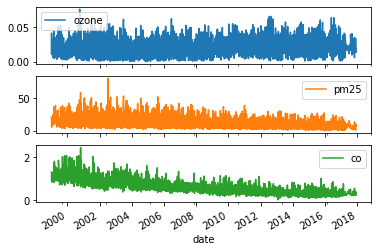

In [ ]:
## pandas
data = pd.read_csv('nyc_air_quality.csv')

# Inspect data
print(data.info())

# Convert the date column to datetime64
data['date'] = pd.to_datetime(data.date)

# Set date column as index
data.set_index('date', inplace=True)

# Inspect data 
print(data.info())

# Plot data
data.plot(subplots=True)
plt.show()

In [ ]:
data.head()

,ozone,pm25,co
date,,,
1999-01-07,0.012024,20.000000,1.300686
1999-02-07,0.027699,23.900000,0.958194
1999-03-07,0.043969,36.700000,1.194444
1999-04-07,0.035162,39.000000,1.081548
1999-05-07,0.038359,28.171429,0.939583


In [ ]:
## pyspark
sp_data = spark.read.format('csv').load('nyc_air_quality.csv', header=True)

# Inspect data
print(sp_data.printSchema())

# Convert the date column to datetime
sp_data = sp_data.withColumn('date', to_date(col('date'), format='dd-MM-yyyy'))

# Set date column as index
# not possible

# Inspect data 
print(sp_data.printSchema())

root
 |-- date: string (nullable = true)
 |-- ozone: string (nullable = true)
 |-- pm25: string (nullable = true)
 |-- co: string (nullable = true)

None
root
 |-- date: date (nullable = true)
 |-- ozone: string (nullable = true)
 |-- pm25: string (nullable = true)
 |-- co: string (nullable = true)

None


In [ ]:
sp_data.show(5)

+----------+--------+---------+--------+
|      date|   ozone|     pm25|      co|
+----------+--------+---------+--------+
|1999-07-01|0.012024|       20|1.300686|
|1999-07-02|0.027699|     23.9|0.958194|
|1999-07-03|0.043969|     36.7|1.194444|
|1999-07-04|0.035162|       39|1.081548|
|1999-07-05|0.038359|28.171429|0.939583|
+----------+--------+---------+--------+
only showing top 5 rows



# Compare annual stock price trends


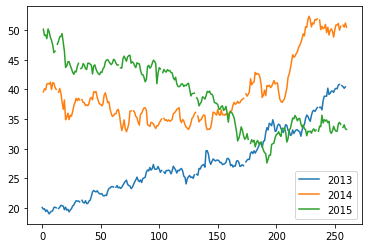

In [ ]:
## pandas
yahoo = pd.read_csv('yahoo_annual_stock_price.csv', parse_dates=['date'], index_col='date')

# Create dataframe prices here
prices = pd.DataFrame()

# Select data for each year and concatenate with prices here 
for year in ['2013', '2014', '2015']:
    price_per_year = yahoo.loc[year, ['price']].reset_index(drop=True)
    price_per_year.rename(columns={'price': year}, inplace=True)
    prices = pd.concat([prices, price_per_year], axis=1)

# Plot prices
prices.plot()
plt.show()

In [ ]:
## pyspark
sp_yahoo = (spark.read.format('csv')
                      .load('yahoo_annual_stock_price.csv', header=True)
                      .withColumn('date', to_date('date', format='yyyy-MM-dd')))

prices = None

# Select data for each year and concatenate with prices here 
for y in [2013, 2014, 2015]:
    price_per_year = sp_yahoo.filter(F.year(col('date')) == y) \
                             .drop('date') \
                             .withColumnRenamed('price', str(y)) \
                             .withColumn('id', row_number().over(
                                 Window.orderBy(monotonically_increasing_id())))
    if prices is None:
        prices = price_per_year
    else:
        prices = prices.join(price_per_year, on='id', how='full')
prices = prices.drop('id')

# Set and change time series frequency


(1898, 3)
(2191, 3)


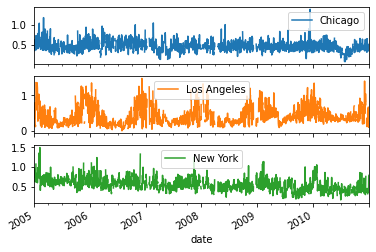

In [ ]:
## pandas

# read the data
co = pd.read_csv('co_cities.csv', parse_dates=['date'], index_col='date')
print(co.shape)

# Set the frequency to calendar daily
co = co.asfreq('D')
print(co.shape)

# Plot the data
co.plot(subplots=True)
plt.show()

(1898, 3)
(72, 3)


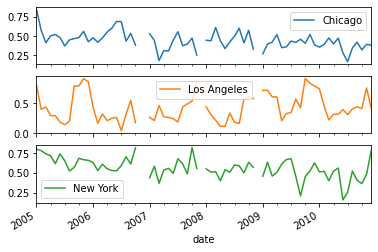

In [ ]:
# read the data
co = pd.read_csv('co_cities.csv', parse_dates=['date'], index_col='date')
print(co.shape)

# Set frequency to monthly
co = co.asfreq('M')
print(co.shape)

# Plot the data
co.plot(subplots=True)
plt.show()

In [ ]:
## pyspark

def asfreq(df, freq, date_col='date'):
    min_date, max_date = (df.agg({date_col: 'min'}).collect()[0][0], 
                          df.agg({date_col: 'max'}).collect()[0][0])
    date_range = spark.createDataFrame(
        pd.DataFrame(pd.date_range(start=min_date, 
                                    end=max_date,
                                    freq=freq),
                        columns=[date_col]))

    return date_range.join(df, on='date', how='left')
        

In [ ]:
## pyspark

# read the data
sp_co = spark.read.format('csv') \
                  .load('co_cities.csv', header=True) \
                  .withColumn('date', to_date('date', format='yyyy-MM-dd'))
print(sp_co.count())

# Set the frequency to calendar daily
sp_co = asfreq(sp_co, freq='D')
print(sp_co.count())

1898
2191


In [ ]:
## pyspark

# read the data
sp_co = spark.read.format('csv') \
                  .load('co_cities.csv', header=True) \
                  .withColumn('date', to_date('date', format='yyyy-MM-dd'))
print(sp_co.count())

# Set frequency to monthly
sp_co = asfreq(sp_co, freq='M')
print(sp_co.count())

1898
72


# Shifting stock prices across time
Let's use this to visually compare a stock price series for Google shifted 90 business days into both past and future.


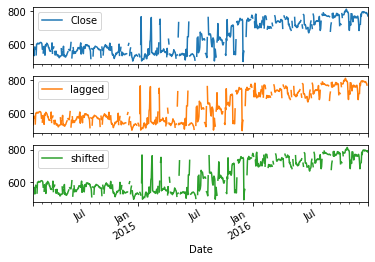

In [ ]:
##  pandas

# Import data here
google = pd.read_csv('google_stock_price.csv', parse_dates=['Date'], 
                     index_col='Date')

# Set data frequency to business daily
google = google.asfreq(freq='B')

# Create 'lagged' and 'shifted'
google['lagged'] = google.Close.shift(-2)
google['shifted'] = google.Close.shift(2)

# Plot the google price series
google.plot(subplots=True)
plt.show()

# Calculating stock price changes using `diff()`
calculate absolute changes from current and shifted prices, and compare the result to the function .diff().

In [11]:
## pandas

# read the data
yahoo = pd.read_csv('yahoo_annual_stock_price.csv', parse_dates=['date'], index_col='date')
print(yahoo.shape)

# Created shifted_30 here
yahoo['shifted_30'] = yahoo.shift(periods=30, freq='B')

# Subtract shifted_30 from price
yahoo['change_30'] = yahoo.price - yahoo.shifted_30

# Get the 30-day price difference
yahoo['diff_30'] = yahoo.price.diff(periods=30)

# Inspect the last five rows of price
print(yahoo.shape)
print(yahoo.tail())

(782, 1)
(782, 4)
            price  shifted_30  change_30  diff_30
date                                             
2015-12-25    NaN       32.19        NaN      NaN
2015-12-28  33.60       32.94       0.66     0.66
2015-12-29  34.04       32.86       1.18     1.18
2015-12-30  33.37       32.98       0.39     0.39
2015-12-31  33.26       32.62       0.64     0.64


In [10]:
# Show the value_counts of the difference between change_30 and diff_30
print(yahoo.change_30.sub(yahoo.diff_30).value_counts(dropna=False))

0.0    703
NaN     79
dtype: int64


# Plotting multi-period returns
`.pct_change()` -  Let's use this function to calculate returns for various calendar day periods, and plot the result to compare the different patterns.


(1094, 1)


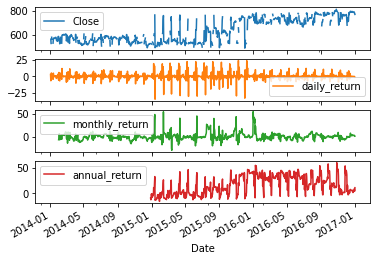

In [12]:
## pandas

# Import data here
google = pd.read_csv('google_stock_price.csv', parse_dates=['Date'], 
                     index_col='Date')
print(google.shape)

# Create daily_return
google['daily_return'] = google.Close.pct_change(periods=1, freq='D')*100

# Create monthly_return
google['monthly_return'] = google.Close.pct_change(periods=30, freq='D')*100

# Create annual_return
google['annual_return'] = google.Close.pct_change(periods=360, freq='D')*100

# Plot the result
google.plot(subplots=True)
plt.show()

# Compare the performance of several asset classes
 let's compare four key assets: stocks, bonds, gold, and oil.
 

(2469, 4)


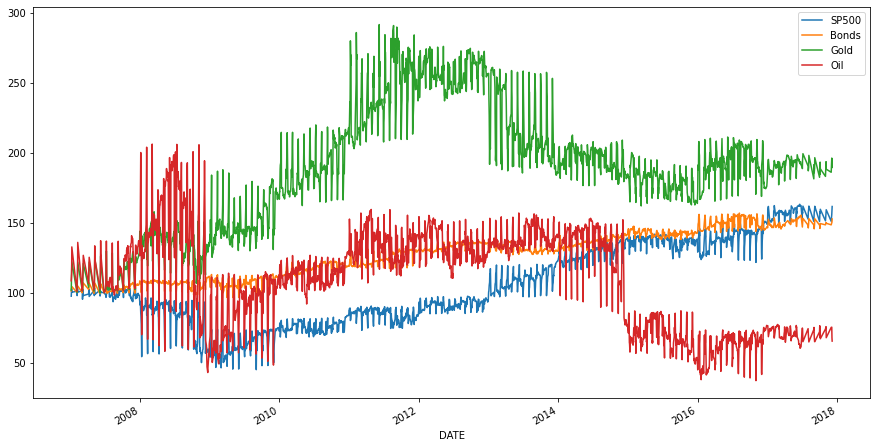

In [21]:
## pandas

# Import data here
prices = pd.read_csv('assets_classes.csv', parse_dates=['DATE'], index_col='DATE')
print(prices.shape)

# Select first prices
first_prices = prices.iloc[0]

# Create normalized
normalized = prices.div(first_prices).mul(100)

# Plot normalized
normalized.plot(figsize=(15, 8))
plt.show()

In [76]:
## pyspark

# Schema
customSchema = StructType([StructField(name='DATE', dataType=StringType(), nullable=True), 
                           StructField('SP500', DoubleType(), True), 
                           StructField('Bonds', DoubleType(), True), 
                           StructField('Gold', DoubleType(), True),
                           StructField('Oil', DoubleType(), True)])

# read the data
sp_prices = spark.read.format('csv') \
                   .load('assets_classes.csv', header=True, schema=customSchema) \
                   .withColumn('DATE', to_date('DATE', format='dd-MM-yyyy'))

# Select first prices
columns = ['SP500', 'Bonds', 'Gold', 'Oil']
first_prices = sp_prices.limit(1).rdd.collect()[0]
first_prices = {c: first_prices[c] for c in columns}

# Create normalized
for c in columns:
    sp_prices = sp_prices.withColumn(c, col(c) / first_prices[c] * 100)

# Comparing stock prices with a benchmark
Comparing the three largest stocks on the NYSE to the Dow Jones Industrial Average, which contains the 30 largest US companies.

The three largest companies on the NYSE are:


    +-------------------------+---------------------------+
    |       Company           |     	Stock Ticker      |
    +-------------------------+---------------------------+
    | Johnson & Johnson       |	          JNJ          |
    +-------------------------+---------------------------+
    | Exxon Mobil             |	          XOM          |
    +-------------------------+---------------------------+
    | JP Morgan Chase         |	          JPM          |
    +-------------------------+---------------------------+
	

(1762, 4)


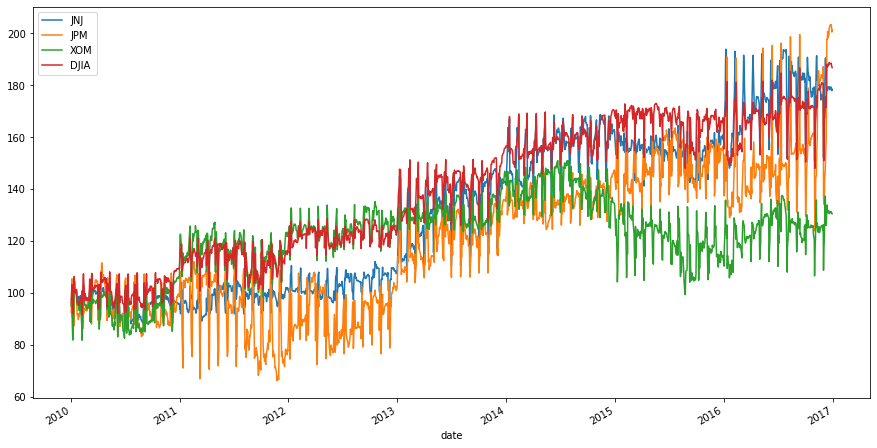

In [81]:
## pandas

# Import stock prices and index here
stocks = pd.read_csv('nyse.csv', parse_dates=['date'], index_col=['date'])
dow_jones = pd.read_csv('dow_jones.csv', parse_dates=['date'], index_col=['date'])

# Concatenate data and inspect result here
data = pd.concat([stocks, dow_jones], axis=1)
print(data.shape)

# Normalize and plot your data here
data.div(data.iloc[0]).mul(100).plot(figsize=(15, 8))
plt.show()

# Plot performance difference vs benchmark index

Calculate and plot the performance difference of a stock in percentage points relative to a benchmark index.

Let's compare the performance of Microsoft (MSFT) and Apple (AAPL) to the S&P 500 over the last 10 years.

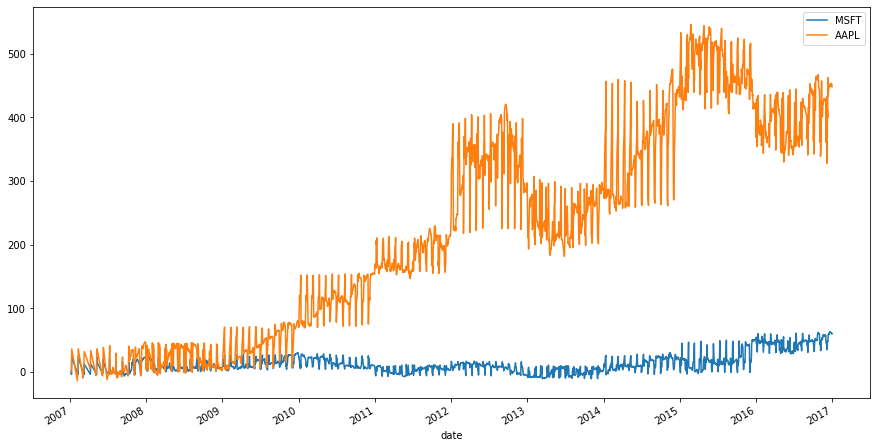

In [87]:
# Create tickers
tickers = ['MSFT', 'AAPL']

# Import stock data here
stocks = pd.read_csv('msft_aapl.csv', parse_dates=['date'], index_col='date')

# Import index here
sp500 = pd.read_csv('sp500.csv', parse_dates=['date'], index_col='date')

# Concatenate stocks and index here
data = pd.concat([stocks, sp500], axis=1).dropna()

# Normalize data
normalized = data.div(data.iloc[0]).mul(100)

# Subtract the normalized index from the normalized stock prices, and plot the result
normalized[tickers].sub(normalized.SP500, axis=0).plot(figsize=(15, 8))
plt.show()

# Convert monthly to weekly data

In [88]:
# Set start and end dates
start = '2016-1-1'
end = '2016-2-29'

# Create monthly_dates here
monthly_dates = pd.date_range(start=start, end=end, freq='M')

# Create and print monthly here
monthly = pd.Series([1, 2], index=monthly_dates)
print(monthly)

2016-01-31    1
2016-02-29    2
Freq: M, dtype: int64


In [93]:
# Create weekly_dates here
weekly_dates = pd.date_range(start=start, end=end, freq='W')
print(weekly_dates)

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28'],
              dtype='datetime64[ns]', freq='W-SUN')


In [90]:
# Print monthly, reindexed using weekly_dates
print(monthly.reindex(weekly_dates))

2016-01-03    NaN
2016-01-10    NaN
2016-01-17    NaN
2016-01-24    NaN
2016-01-31    1.0
2016-02-07    NaN
2016-02-14    NaN
2016-02-21    NaN
2016-02-28    NaN
Freq: W-SUN, dtype: float64


In [91]:
# Print monthly, reindexed using weekly_dates using backward fill
print(monthly.reindex(weekly_dates, method='bfill'))

2016-01-03    1
2016-01-10    1
2016-01-17    1
2016-01-24    1
2016-01-31    1
2016-02-07    2
2016-02-14    2
2016-02-21    2
2016-02-28    2
Freq: W-SUN, dtype: int64


In [92]:
# Print monthly, reindexed using weekly_dates using foreward fill
print(monthly.reindex(weekly_dates, method='ffill'))

2016-01-03    NaN
2016-01-10    NaN
2016-01-17    NaN
2016-01-24    NaN
2016-01-31    1.0
2016-02-07    1.0
2016-02-14    1.0
2016-02-21    1.0
2016-02-28    1.0
Freq: W-SUN, dtype: float64


# Create weekly data from monthly unemployment data

In [95]:
# Import data here
data = pd.read_csv('unemployment.csv', parse_dates=['date'], index_col='date')

# Show first five rows of weekly series
print(data.asfreq('W').head())

            UNRATE
date              
2000-01-02     4.1
2000-01-09     3.9
2000-01-16     NaN
2000-01-23     NaN
2000-01-30     NaN


In [96]:
# Show first five rows of weekly series with bfill option
print(data.asfreq('W', method='bfill').head())

            UNRATE
date              
2000-01-02     4.1
2000-01-09     3.9
2000-01-16     4.2
2000-01-23     4.2
2000-01-30     4.2


In [97]:
# Create weekly series with ffill option and show first five rows
weekly_ffill = data.asfreq('W', method='ffill')
print(weekly_ffill.head())

            UNRATE
date              
2000-01-02     4.1
2000-01-09     3.9
2000-01-16     3.9
2000-01-23     3.9
2000-01-30     3.9


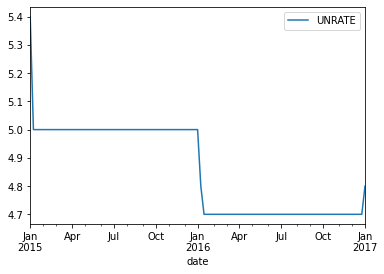

In [98]:
# Plot weekly_fill starting 2015 here 
weekly_ffill.loc['2015':].plot()
plt.show()

# Use interpolation to create weekly employment data

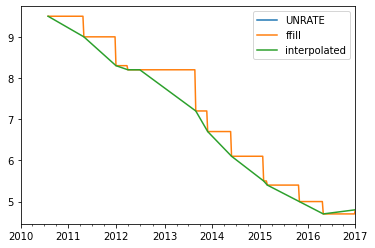

In [100]:
## pandas

# Inspect data here
monthly = pd.read_csv('unrate.csv', parse_dates=['DATE'], index_col='DATE')

# Create weekly dates
weekly_dates = pd.date_range(start=monthly.index.min(),
                            end=monthly.index.max(), freq='W')

# Reindex monthly to weekly data (upsampling)
weekly = monthly.reindex(weekly_dates)

# Create ffill and interpolated columns
weekly['ffill'] = weekly.ffill()
weekly['interpolated'] = weekly.UNRATE.interpolate(method='linear')

# Plot weekly
weekly.plot()
plt.show()

# Interpolate debt/GDP and compare to unemployment

In [103]:
# Import & inspect data here
data = pd.read_csv('debt_unemployment.csv', parse_dates=['date'], index_col='date')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2010-01-01 to 2017-01-05
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Debt/GDP      29 non-null     float64
 1   Unemployment  89 non-null     float64
dtypes: float64(2)
memory usage: 2.1 KB
None


In [104]:
# Interpolate and inspect here
interpolated = data.interpolate()
print(interpolated.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2010-01-01 to 2017-01-05
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Debt/GDP      89 non-null     float64
 1   Unemployment  89 non-null     float64
dtypes: float64(2)
memory usage: 2.1 KB
None


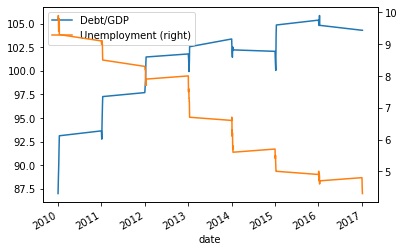

In [105]:
# Plot interpolated data here
interpolated.plot(secondary_y='Unemployment')
plt.show()

# Downsampling & aggregation - Compare weekly, monthly and annual ozone trends for NYC & LA


(6291, 2)


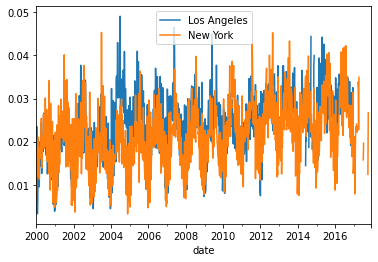

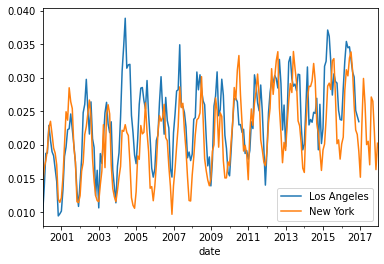

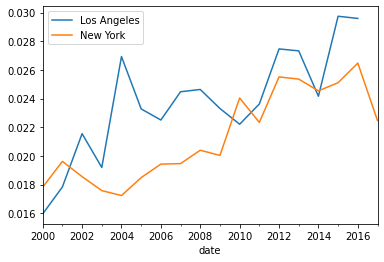

In [108]:
# Import and inspect data here
ozone = pd.read_csv('ozone.csv', parse_dates=['date'], index_col='date')
print(ozone.shape)

# Calculate and plot the weekly average ozone trend
ozone.resample(rule='W').mean().plot()
plt.show()

# Calculate and plot the monthly average ozone trend
ozone.resample(rule='M').mean().plot()
plt.show()

# Calculate and plot the annual average ozone trend
ozone.resample(rule='A').mean().plot()
plt.show()

# Visualize monthly mean, median and standard deviation of S&P500 returns

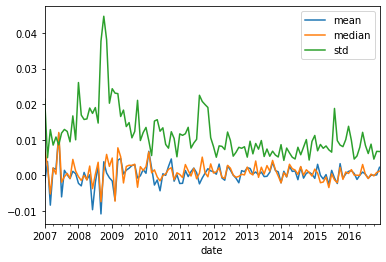

In [110]:
# Import data here
sp500 = pd.read_csv('sp500.csv', parse_dates=['date'], index_col='date')

# Calculate daily returns here
daily_returns = sp500.squeeze().pct_change(periods=1)

# Resample and calculate statistics
stats = daily_returns.resample('M').agg(['mean', 'median', 'std'])

# Plot stats here
stats.plot()
plt.show()